In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [2]:
static_ds = xr.open_dataset('/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/training/inputs/static_fields/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

land_mask = static_ds.sftlf

# directories
ml_output_dir = '//nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/inference/output/'
CCAM_dir = '/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/'

result_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/image_errors'


# TEMPORAL TRAINING EXPERIMENTS
temporal_experiments = ['pr_ACCESS-CM2_5','pr_ACCESS-CM2_10','pr_ACCESS-CM2_20','pr_ACCESS-CM2_30','pr_ACCESS-CM2_40',
                        'pr_ACCESS-CM2_50','pr_ACCESS-CM2_60','pr_ACCESS-CM2_80','pr_ACCESS-CM2_100','pr_ACCESS-CM2_120',
                        'pr_ACCESS-CM2_140','pr_ACCESS-CM2_1961-1980','pr_ACCESS-CM2_2015-2034','pr_ACCESS-CM2_2080-2099']

base_period = ['1985','2004']
future_period = ['2080','2099']

In [3]:
def compute_daily_rmse(ccam,ml):
    
    rmse = (mean_squared_error(ccam.values.flatten(),ml.values.flatten()))**(1/2)
    
    return(rmse)

def load_emulator_data(GCM,emulator,epoch,gan_flag,coarsen_param):

    # Emulator - imperfect
    imperfect_hist = xr.open_dataset(f'{ml_output_dir}/{GCM}/{emulator}/{GCM}_{var}_historical_imperfect_framework_{gan_flag}_epoch_{str(epoch)}.nc')[var]
    #imperfect_future = xr.open_dataset(f'{ml_output_dir}/{GCM}/{emulator}/{GCM}_{var}_ssp370_imperfect_framework_{gan_flag}_epoch_{str(epoch)}.nc')[var]
    imperfect_da = imperfect_hist.sel(time=slice(years[0],years[1]))
    imperfect_da = imperfect_da.sel(time=~((imperfect_da['time'].dt.month == 2) & (imperfect_da['time'].dt.day == 29)))
    if coarsen_param > 0:
        imperfect_da = imperfect_da.coarsen(lat=coarsen_param,lon=coarsen_param,boundary='trim').max()
    
    #imperfect_da = xr.concat([imperfect_hist,imperfect_future],dim='time')

    # Emulator - perfect
    perfect_da = xr.open_dataset(f'{ml_output_dir}/{GCM}/{emulator}/{GCM}_{var}_ssp370_perfect_framework_{gan_flag}_epoch_{str(epoch)}.nc')[var]
    perfect_da = perfect_da.sel(time=slice(years[0],years[1]))
    perfect_da = perfect_da.sel(time=~((perfect_da['time'].dt.month == 2) & (perfect_da['time'].dt.day == 29)))
    if coarsen_param > 0:
        perfect_da = perfect_da.coarsen(lat=coarsen_param,lon=coarsen_param,boundary='trim').max()

    da_dict = {'imperfect':imperfect_da, 'perfect':perfect_da}

    return(da_dict)#perfect_da
    
def write_to_dict(result_dict,full,gcm,emulator,framework,period_name,var,metric,error_type,gan_flag,sampling,epoch,coarsen_method,coarsen_param):
    
    result_dict['whole region'].append(full)
    result_dict['GCM'].append(gcm)
    result_dict['emulator'].append(emulator)
    result_dict['framework'].append(framework)
    result_dict['error period'].append(period_name)
    result_dict['var'].append(var)
    result_dict['metric'].append(metric)
    result_dict['error type'].append(error_type)
    result_dict['model_type'].append(gan_flag)
    result_dict['sampling_n'].append(sampling)
    result_dict['epoch'].append(epoch)
    result_dict['coarsen_method'].append(coarsen_method)
    result_dict['coarsen_param'].append(coarsen_param)
    


    

In [4]:
result_dict = {'GCM':[],'emulator':[],'framework':[],'error period':[],'var':[],'metric':[],'error type':[],\
               'whole region':[],'sampling_n':[],'model_type':[],'epoch':[],'coarsen_method':[],'coarsen_param':[]}


gcm = 'EC-Earth3'
years = ('1990','1994')
epoch = '230'
period_name = '-'.join(years)
var = 'pr'
metric = 'daily_max'
error_type = 'RMSE'
coarsen_method = 'max'

for coarsen_param in [0,20]:
    
    # CCAM dynamical downscaled output
    print('loading ccam')
    CCAM_downscaled_da = xr.open_dataset(f'{CCAM_dir}/target_fields/target_fields_hist_ssp370_concat.nc')['pr']
    ccam = CCAM_downscaled_da.sel(GCM=gcm,time=slice(years[0],years[1]))
    if var == 'pr':
        ccam = ccam*86400 # convert from flux to mm/day
        
    if coarsen_param > 0:
        ccam = ccam.coarsen(lat=coarsen_param,lon=coarsen_param,boundary='trim').max()

    for ml_type in ['GAN','unet']:
        print(ml_type)
        
        for emulator in temporal_experiments:

            print(f'loading: {emulator}')

            sampling = emulator.split('_')[-1]

            ml_dict = load_emulator_data(gcm,emulator,epoch,ml_type,coarsen_param)
            
            for framework in ['perfect','imperfect']:

                rmse = compute_daily_rmse(ccam,ml_dict[framework])

                write_to_dict(result_dict,rmse,gcm,emulator,framework,period_name,var,metric,error_type,ml_type,sampling,epoch,coarsen_method,coarsen_param)

loading ccam
GAN
loading: pr_ACCESS-CM2_5
loading: pr_ACCESS-CM2_10
loading: pr_ACCESS-CM2_20
loading: pr_ACCESS-CM2_30
loading: pr_ACCESS-CM2_40
loading: pr_ACCESS-CM2_50
loading: pr_ACCESS-CM2_60
loading: pr_ACCESS-CM2_80
loading: pr_ACCESS-CM2_100
loading: pr_ACCESS-CM2_120
loading: pr_ACCESS-CM2_140
loading: pr_ACCESS-CM2_1961-1980
loading: pr_ACCESS-CM2_2015-2034
loading: pr_ACCESS-CM2_2080-2099
unet
loading: pr_ACCESS-CM2_5
loading: pr_ACCESS-CM2_10
loading: pr_ACCESS-CM2_20
loading: pr_ACCESS-CM2_30
loading: pr_ACCESS-CM2_40
loading: pr_ACCESS-CM2_50
loading: pr_ACCESS-CM2_60
loading: pr_ACCESS-CM2_80
loading: pr_ACCESS-CM2_100
loading: pr_ACCESS-CM2_120
loading: pr_ACCESS-CM2_140
loading: pr_ACCESS-CM2_1961-1980
loading: pr_ACCESS-CM2_2015-2034
loading: pr_ACCESS-CM2_2080-2099
loading ccam
GAN
loading: pr_ACCESS-CM2_5
loading: pr_ACCESS-CM2_10
loading: pr_ACCESS-CM2_20
loading: pr_ACCESS-CM2_30
loading: pr_ACCESS-CM2_40
loading: pr_ACCESS-CM2_50
loading: pr_ACCESS-CM2_60
loadin

In [5]:
error_df = pd.DataFrame.from_dict(result_dict)
error_df.to_csv(f'{result_dir}/daily_RMSE.csv')


In [43]:
error_df

,GCM,emulator,framework,error period,var,metric,error type,whole region,sampling_n,model_type,epoch,coarsen_method,coarsen_param
0,EC-Earth3,pr_ACCESS-CM2_5,perfect,1990-1994,pr,daily_max,RMSE,7.482877,5,GAN,230,max,0
1,EC-Earth3,pr_ACCESS-CM2_10,perfect,1990-1994,pr,daily_max,RMSE,7.377859,10,GAN,230,max,0
2,EC-Earth3,pr_ACCESS-CM2_20,perfect,1990-1994,pr,daily_max,RMSE,7.161172,20,GAN,230,max,0
3,EC-Earth3,pr_ACCESS-CM2_30,perfect,1990-1994,pr,daily_max,RMSE,7.572717,30,GAN,230,max,0
4,EC-Earth3,pr_ACCESS-CM2_40,perfect,1990-1994,pr,daily_max,RMSE,7.233623,40,GAN,230,max,0
5,EC-Earth3,pr_ACCESS-CM2_50,perfect,1990-1994,pr,daily_max,RMSE,6.934916,50,GAN,230,max,0
6,EC-Earth3,pr_ACCESS-CM2_60,perfect,1990-1994,pr,daily_max,RMSE,6.937833,60,GAN,230,max,0
7,EC-Earth3,pr_ACCESS-CM2_80,perfect,1990-1994,pr,daily_max,RMSE,7.041325,80,GAN,230,max,0
8,EC-Earth3,pr_ACCESS-CM2_100,perfect,1990-1994,pr,daily_max,RMSE,7.008686,100,GAN,230,max,0
9,EC-Earth3,pr_ACCESS-CM2_120,perfect,1990-1994,pr,daily_max,RMSE,6.942627,120,GAN,230,max,0


Text(0.5, 0.98, 'daily RMSE, coarsen method = max()')

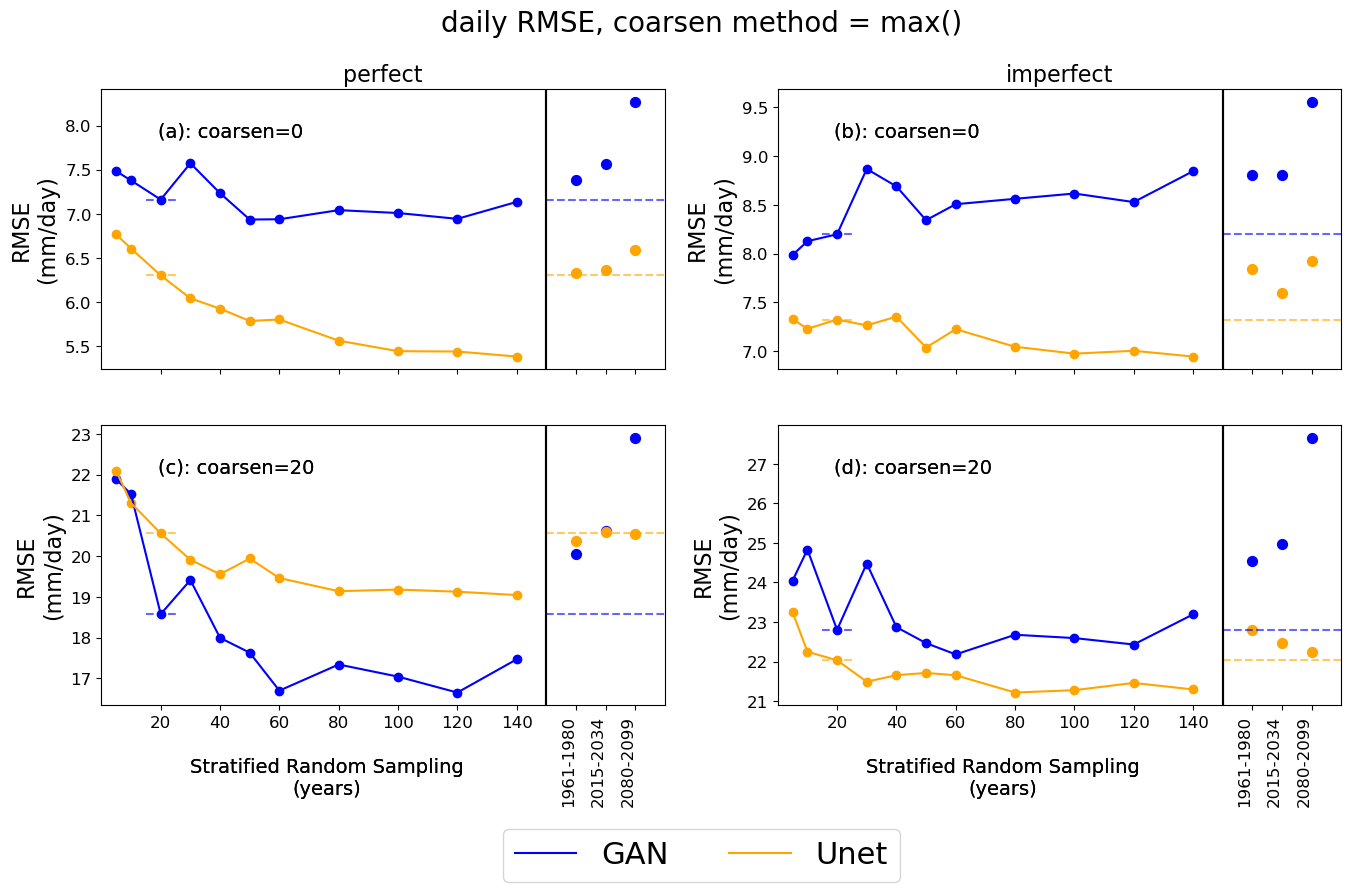

In [7]:
colors = {'GAN':'blue','unet':'orange'}
capitalized = {'GAN':'GAN','unet':'Unet','rx1d':'Rx1d','annual_mean':'Annual Mean',\
               'DJF_mean':'DJF Mean','JJA_mean':'JJA Mean','total_max':'Total Max'}

region = 'whole region'

x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}

subplot_labels = [['(a)','(b)'],
                  ['(c)','(d)']]


fig,axs = plt.subplots(2,2,figsize=(16,8),sharex=True)

for i,coarsen_param in enumerate([0,20]):
    
    for j,framework in enumerate(['perfect','imperfect']):
        
        framework_df = error_df[error_df['framework']==framework]
        
        for ml_type in ['GAN','unet']:

            ml_type_df = framework_df[framework_df['model_type']==ml_type]

            df = ml_type_df[ml_type_df['coarsen_param']==coarsen_param]
            df.index = df['sampling_n']
            df = df['whole region']

            results_n = df[~df.index.isin(['1961-1980','2015-2034','2080-2099'])]
            results_n.index = results_n.index.astype(int)
            results_n = results_n.sort_index()

            results_20 = df[df.index.isin(['1961-1980','2015-2034','2080-2099'])]

            # PLOTTING
            # dashed line at 20-year random sampling
            random_20_val = results_n[20]
            axs[i][j].hlines(random_20_val,15,25,color=colors[ml_type],linestyle='--',alpha=0.6)
            axs[i][j].hlines(random_20_val,150,190,color=colors[ml_type],linestyle='--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')

            # n samples
            x = [int(v) for v in results_n.index]
            axs[i][j].scatter(x,results_n,color=colors[ml_type])
            axs[i][j].plot(x,results_n,label=capitalized[ml_type],color=colors[ml_type])

            # 20-year samples
            for k,index in enumerate(results_20.index):
                x_val = x_ticks[index]
                axs[i][j].scatter(x_val,results_20.loc[index],s=50, color=colors[ml_type])#,marker=markers[k],facecolors='none'

            # AXIS DECORATION
            axs[i][j].set_ylabel('RMSE\n(mm/day)',fontsize=16)

            axs[i][j].text(0.1, 0.85, f'{subplot_labels[i][j]}: coarsen={coarsen_param}', va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=14)
            axs[i][j].axvline([150],color='black')
            axs[i][j].tick_params(axis='y', labelsize=12)
            axs[i][j].set_xlim(0,190)

            if i == 1:
                # x axis label
                axs[i][j].text(0.4, -0.26, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=14)

                # configure xticks and labels
                positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
                labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

                # Set all at once
                axs[i][j].set_xticks(positions)
                axs[i][j].set_xticklabels(labels, fontsize=12)

                # Rotate only the "future period" labels
                for pos, label in zip(positions, axs[i][j].get_xticklabels()):
                    if pos >= 160:
                        label.set_rotation(90)
                        label.set_ha('right')
                        
            else:
                axs[i][j].set_title(framework,fontsize=16)

handles, labels = axs[0][0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.13),fontsize=22)

fig.suptitle('daily RMSE, coarsen method = max()',fontsize=20)

In [7]:
error_df

,GCM,emulator,framework,error period,var,metric,error type,whole region,land,ocean,sampling_n,model_type,epoch
0,ACCESS-CM2,pr_ACCESS-CM2_5,perfect,1985_2004,pr,annual_mean,MAE,0.501236,0.928479,0.464069,5,GAN,220
1,ACCESS-CM2,pr_ACCESS-CM2_5,imperfect,1985_2004,pr,annual_mean,MAE,0.386046,0.802615,0.349808,5,GAN,220
2,ACCESS-CM2,pr_ACCESS-CM2_5,perfect,2080_2099,pr,annual_mean,MAE,0.668393,1.130344,0.628207,5,GAN,220
3,ACCESS-CM2,pr_ACCESS-CM2_5,imperfect,2080_2099,pr,annual_mean,MAE,0.545158,0.937250,0.511048,5,GAN,220
4,ACCESS-CM2,pr_ACCESS-CM2_5,perfect,CC_signal,pr,annual_mean,MAE,8.456807,9.406641,8.374178,5,GAN,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16123,EC-Earth3,pr_ACCESS-CM2_2080-2099,imperfect,1985_2004,pr,JJA_mean,RMSE,1.203341,1.359042,1.188832,2080-2099,unet,230
16124,EC-Earth3,pr_ACCESS-CM2_2080-2099,perfect,2080_2099,pr,JJA_mean,RMSE,1.184820,1.456355,1.158192,2080-2099,unet,230
16125,EC-Earth3,pr_ACCESS-CM2_2080-2099,imperfect,2080_2099,pr,JJA_mean,RMSE,1.175317,1.412140,1.152416,2080-2099,unet,230
16126,EC-Earth3,pr_ACCESS-CM2_2080-2099,perfect,CC_signal,pr,JJA_mean,RMSE,10.695893,12.535995,10.520611,2080-2099,unet,230
